In [16]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'


In [17]:
from functools import partial
import jax
from jax import random, grad, jit, vmap, flatten_util, nn
#from jax.experimental import optix
import optax
from jax.config import config
import jax.numpy as np

import haiku as hk

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import os
import cv2

import imageio
import json
import pickle

rng = jax.random.PRNGKey(42)

In [21]:
os.getcwd()

'/home/wonbong/models/learnit/Experiments'

# Data

../data/shapenet/03001627/116bcb3b43de74b9df9054bbcf5c6adc
(50, 128, 128, 3)


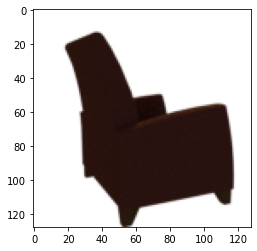

In [22]:
SPLITS_FILE = '../data/shapenet/chair_splits.json' # Update
DATA_PATH = '../data/shapenet/03001627/' # Update

import json
import imageio

def load_train_ex(train_ex_dir, key=None):
    
    with open(os.path.join(train_ex_dir, 'transforms.json'), 'r') as fp:
        meta = json.load(fp)

    camera_angle_x = float(meta['camera_angle_x'])

    imgs = []
    bkgds = []
    poses = []
    for idx in np.arange(len(meta['frames'])):
        frame = meta['frames'][idx]
        fname = os.path.join(train_ex_dir, os.path.basename(frame['file_path']) + '.png')
        imgs.append(imageio.imread(fname))
        poses.append(np.array(frame['transform_matrix']))
    H, W = imgs[0].shape[:2]
    focal = .5 * W / np.tan(.5 * camera_angle_x)
    imgs = (np.array(imgs) / 255.).astype(np.float32)
    imgs = imgs[...,:3] * imgs[...,-1:] + 1-imgs[...,-1:]
    poses = np.array(poses).astype(np.float32)

    return imgs, poses, [H,W,focal]

with open(SPLITS_FILE, "r") as read_file:
    splits = json.load(read_file)

train_exs = [os.path.join(DATA_PATH, d) for d in sorted(splits['train'])]
test_exs =[os.path.join(DATA_PATH, d) for d in sorted(splits['test'])]
val_exs = [os.path.join(DATA_PATH, d) for d in sorted(splits['val'])]
for i in range(1):
    val_ex = val_exs[i]
    print(val_ex)
    images, poses, hwf = load_train_ex(val_ex, rng)
    print(images.shape)
    plt.imshow(images[0])
    plt.show()

# NeRF Model and Rendering

In [23]:
def get_rays(H, W, focal, c2w):
    i, j = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = np.broadcast_to(c2w[:3,-1], rays_d.shape)
    return np.stack([rays_o, rays_d], 0)

get_rays = jit(get_rays, static_argnums=(0, 1))
get_ray_batch = jax.vmap(get_rays, in_axes=[None, None, None, 0], out_axes=1)

In [24]:
def render_rays(rnd_input, model, params, rays, N_samples, rand=False, allret=False):
    rays_o, rays_d = rays
    
    near = 2
    far = 6

    # Compute 3D query points
    z_vals = np.linspace(near, far, N_samples) 
    if rand:
        z_vals += random.uniform(rnd_input, shape=list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = np.reshape(pts, [-1,3])
        
    raw = model.apply(params, pts_flat)
    raw = np.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    rgb, sigma_a = raw[...,:3], raw[...,3]
    sigma_a = jax.nn.relu(sigma_a)
    rgb = jax.nn.sigmoid(rgb) 
    
    # Do volume rendering
    dists = np.concatenate([z_vals[..., 1:] - z_vals[..., :-1], np.broadcast_to([1e-3], z_vals[...,:1].shape)], -1) 
    alpha = 1. - np.exp(-sigma_a * dists)
    trans = np.minimum(1., 1. - alpha + 1e-10)
    trans = np.concatenate([np.ones_like(trans[...,:1]), trans[...,:-1]], -1)  
    weights = alpha * np.cumprod(trans, -1)
    
    rgb_map = np.sum(weights[...,None] * rgb, -2)
    acc_map = np.sum(weights, -1)    
    rgb_map = rgb_map + (1.-acc_map[...,None]) # white background 
    
    if False:
        rgb_map = rgb_map + (1.-acc_map[..., None])
    
    if not allret:
        return rgb_map
    
    depth_map = np.sum(weights * z_vals, -1) 

    return rgb_map, depth_map, acc_map

def render_fn_inner(rnd_input, model, params, rays, rand, allret, N_samples):
    return render_rays(rnd_input, model, params, rays, N_samples=N_samples, rand=rand, allret=allret)
render_fn_inner = jit(render_fn_inner, static_argnums=(1, 4, 5, 6))

def render_fn(rnd_input, model, params, rays, N_samples, rand):
    chunk = 5
    for i in range(0, rays.shape[1], chunk):
        out = render_fn_inner(rnd_input, model, params, rays[:,i:i+chunk], rand, True, N_samples)
        if i==0:
            rets = out
        else:
            rets = [np.concatenate([a, b], 0) for a, b in zip(rets, out)]
    return rets

In [25]:
class Model(hk.Module):
    def __init__(self):
        super().__init__()
        self.width = 256
        self.depth = 6
        self.use_viewdirs = False
                
    def __call__(self, coords, view_dirs=None):
        sh = coords.shape
        if self.use_viewdirs:
            viewdirs = None
            viewdirs = np.repeat(viewdirs[...,None,:], coords.shape[-2], axis=-2)
            viewdirs /= np.linalg.norm(viewdirs, axis=-1, keepdims=True)
            viewdirs = np.reshape(viewdirs, (-1,3))
            viewdirs = hk.Linear(output_size=self.width//2)(viewdirs)
            viewdirs = jax.nn.relu(viewdirs)
        coords = np.reshape(coords, [-1,3])
        
        x = np.concatenate([np.concatenate([np.sin(coords*(2**i)), np.cos(coords*(2**i))], axis=-1) for i in np.linspace(0,8,20)], axis=-1)

        for _ in range(self.depth-1):
            x = hk.Linear(output_size=self.width)(x)
            x = jax.nn.relu(x)
            
        if self.use_viewdirs:
            density = hk.Linear(output_size=1)(x)
            x = np.concatenate([x,viewdirs], axis=-1)
            x = hk.Linear(output_size=self.width)(x)
            x = jax.nn.relu(x)
            rgb = hk.Linear(output_size=3)(x)
            out = np.concatenate([density, rgb], axis=-1)
        else:
            out = hk.Linear(output_size=4)(x)
        out = np.reshape(out, list(sh[:-1]) + [4])
        return out

# Meta Train

In [26]:
plt_groups = {'Train PSNR':[], 'Test PSNR':[]}
plotlosses_model = PlotLosses(groups=plt_groups)

In [27]:
exp_name = 'chairs'
max_iters = 100001
batch_size = 128

num_views = 25
test_time_views = 1

inner_update_steps = 32
inner_step_size = .5
lr = 5e-4

checkpoint_dir = 'checkpoint/shapenet_checkpoints/'

N_samples = 128

model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))
params = model.init(rng, np.ones((1,3)))

test_inner_steps = 128*128 * 4 // batch_size

mse_fn = jit(lambda x, y: np.mean((x - y)**2))
psnr_fn = jit(lambda x, y: -10 * np.log10(mse_fn(x, y)))

# update inner model network weights with once step of sgd
@jit
def single_step(rng, images, rays, params, idx):
    def sgd(param, update):
        return param - inner_step_size * update

    def loss_fn(params, rng_inputs):
        idx = random.randint(rng_inputs[0], shape=(batch_size,), minval=0, maxval=images.shape[0])
        image_sub = images[idx,:]
        rays_sub = rays[:,idx,:]

        g = render_rays(rng_inputs[1], model, params, rays_sub, N_samples, rand=True)
        return mse_fn(g, image_sub)

    rng, *rng_inputs = jax.random.split(rng, 3)
    loss, grad = jax.value_and_grad(loss_fn)(params, rng_inputs)
    params = jax.tree_multimap(sgd, params, grad)
    return rng, params, loss

# update inner model network weights inner_update_steps number of times
def update_network_weights(rng, images, rays, params):
    for _ in range(inner_update_steps):
        idx = random.randint(rng, shape=(batch_size,), minval=0, maxval=images.shape[0])
        rng, params, loss = single_step(rng, images, rays, params, idx)
    return rng, params, loss

# update meta model weights based on trained inner model weights
def update_model(rng, params, opt_state, images, rays):
    rng, new_params, model_loss = update_network_weights(rng, images, rays, params)

    def calc_grad(params, new_params):
        return params - new_params

    model_grad = jax.tree_multimap(calc_grad, params, new_params)
    updates, opt_state = opt.update(model_grad, opt_state)
    params = optix.apply_updates(params, updates)
    return rng, params, opt_state, model_loss

# train meta model inner_steps number of times to evaluate meta parameters
def update_network_weights_test(rng, images, rays, params, inner_steps):
    lowest_loss = 1e7
    for _ in range(inner_steps):
        idx = random.randint(rng, shape=(batch_size,), minval=0, maxval=images.shape[0])
        rng, params, loss = single_step(rng, images, rays, params, idx)
        if loss < lowest_loss:
            lowest_loss = loss
    return rng, params, lowest_loss


opt = optix.adam(lr)
opt_state = opt.init(params)

plt_groups['Train PSNR'].append(exp_name+f'_train')
plt_groups['Test PSNR'].append(exp_name+f'_test')
step = 0
train_psnrs = []
rng = jax.random.PRNGKey(0)

train_size = len(train_exs)
test_psnrs = []

for step in range(max_iters):
    try:
        rng, rng_input = jax.random.split(rng)
        img_idx = random.randint(rng, shape=(1,), minval=0, maxval=train_size)
        images, poses, hwf = load_train_ex(train_exs[img_idx[0]], rng)

        images = images[:num_views]
        poses = poses[:num_views]
    except:
        continue
    images = np.reshape(images, (-1,3))

    rays = get_ray_batch(hwf[0], hwf[1], hwf[2], poses)
    rays = np.reshape(rays, (2,-1,3))

    rng, params, opt_state, loss = update_model(rng, params, opt_state, images, rays)
    train_psnrs.append(-10 * np.log10(loss))

    if step == 0:
        plotlosses_model.update({exp_name+'_train':np.mean(np.array(train_psnrs))}, current_step=step)
        train_psnrs = []
    if step % 1000 == 0 and step != 0:
        plotlosses_model.update({exp_name+'_train':np.mean(np.array(train_psnrs))}, current_step=step)
        train_psnr = float(np.mean(np.array(train_psnrs)))  
        train_psnrs = []

        test_psnr = []
        for i in range(5):
            images, poses, hwf = load_train_ex(val_exs[0], rng)
            test_holdout_images, test_images = np.split(images, [25], axis=0)
            test_holdout_poses, test_poses = np.split(poses, [25], axis=0)

            test_rays = get_ray_batch(hwf[0], hwf[1], hwf[2], test_poses)
            
            test_images = test_images[:test_time_views]
            test_rays = test_rays[:test_time_views]

            test_images = np.reshape(test_images, (-1,3))
            test_rays = np.reshape(test_rays, (2,-1,3))
            rng, test_params, test_inner_loss = update_network_weights_test(rng, test_images, test_rays, params, test_inner_steps)

            test_holdout_rays = get_rays(hwf[0], hwf[1], hwf[2], test_holdout_poses[0])
            test_result = np.clip(render_fn(rng, model, test_params, test_holdout_rays, N_samples, rand=False)[0], 0, 1)
            test_psnr.append(psnr_fn(test_holdout_images[0], test_result))

        test_psnr = np.mean(np.array(test_psnr))
        test_psnrs.append(test_psnr)
        plotlosses_model.update({exp_name+'_test':test_psnr}, current_step=step)
        plotlosses_model.send()

        plt.figure(figsize=(15, 5))   
        plt.subplot(1, 2, 1)
        plt.imshow(test_holdout_images[0])
        plt.subplot(1, 2, 2)
        plt.imshow(test_result)
        plt.show()
    if step % 10000 == 0 and step != 0:
        pickle.dump(params, open(f"{checkpoint_dir}/{exp_name}_{step}.pkl", 'wb'))

NameError: name 'optix' is not defined

# Test-time optimization

In [28]:
def train_single_model(max_iters, rng, num_views=25, lr=1e-4, batch_size=64, N_samples=128, init_params=None, image_idx=0):

    model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))

    if init_params !=None:
        params = init_params
    else:
        params = model.init(rng, np.ones((1,3)))

    opt = optix.sgd(lr)
    opt_state = opt.init(params)

    mse_fn = jit(lambda x, y: np.mean((x - y)**2))
    psnr_fn = jit(lambda x, y: -10 * np.log10(mse_fn(x, y)))

    @jit
    def update_model(rng, params, opt_state, image, rays):
        rng, rng_inputs = jax.random.split(rng)
        def loss_model(params):
            g = render_rays(rng_inputs, model, params, rays, N_samples, rand=True, )
            return mse_fn(g, image)
        model_loss, model_grad = jax.value_and_grad(loss_model, argnums=0)(params)
        updates, opt_state = opt.update(model_grad, opt_state)
        params = optix.apply_updates(params, updates)
        return rng, params, opt_state, model_loss

    images, poses, hwf = load_train_ex(test_exs[image_idx], rng)
    images, test_images = np.split(images, [25], axis=0)
    poses, test_poses = np.split(poses, [25], axis=0)

    images = images[:num_views]
    poses = poses[:num_views]
    
    H, W, focal = hwf
    rays = get_ray_batch(H, W, focal, poses)

    images_ = images
    images = np.reshape(images, (-1,3))
    rays = np.reshape(rays, (2,-1,3))

    for step in range(max_iters):
        idx = random.randint(rng, shape=(batch_size,), minval=0, maxval=(images.shape[0]))
        train_image = images[idx,:]
        train_rays = rays[:,idx,:]

        rng, params, opt_state, loss = update_model(rng, params, opt_state, train_image, train_rays)

    return params, images_


### Load Checkpoint (optional)

In [46]:
checkpoint_file = 'checkpoint/shapenet_checkpoints/chair_meta_params_25_view_train.pkl'

with open(checkpoint_file, 'rb') as file:
    params = pickle.load(file)

### Run TTO and render results

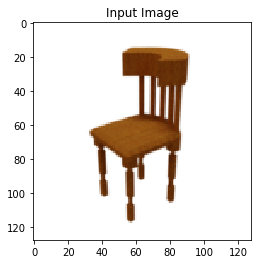

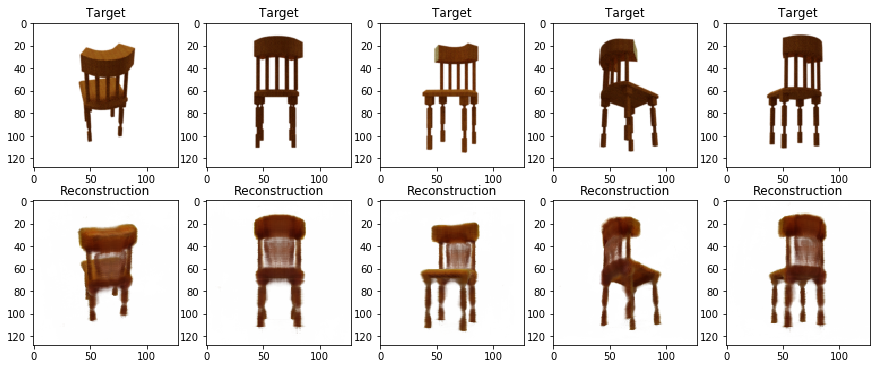

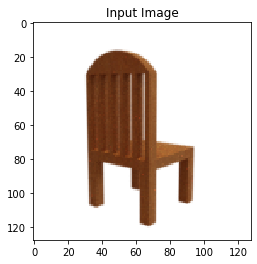

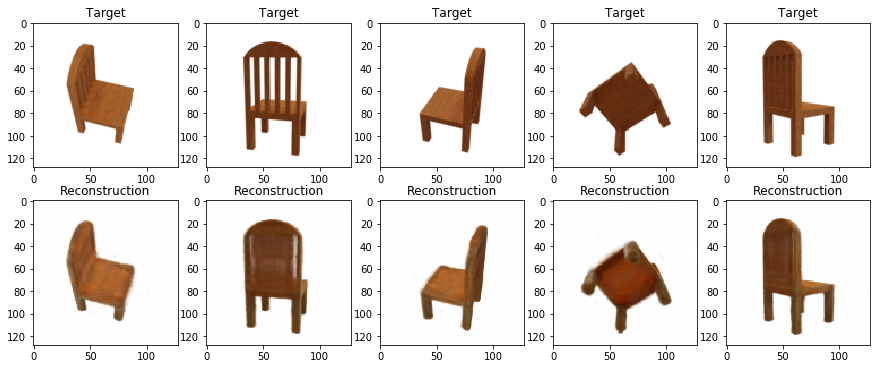

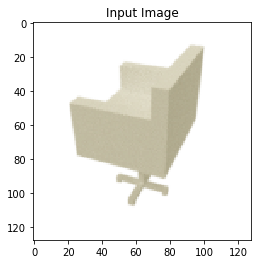

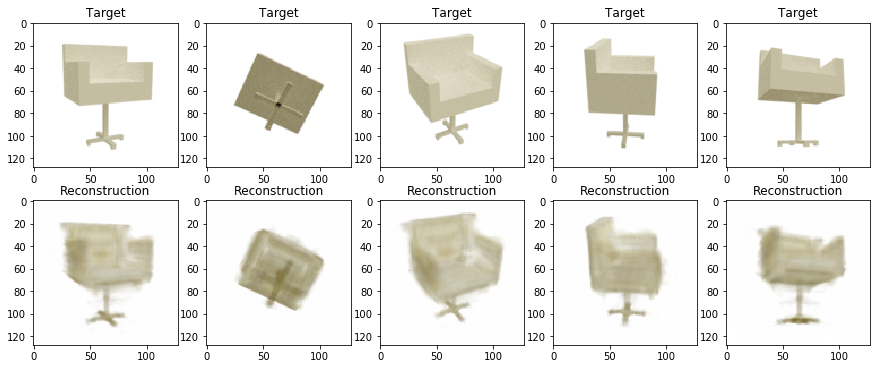

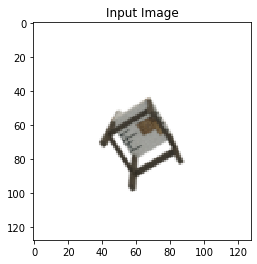

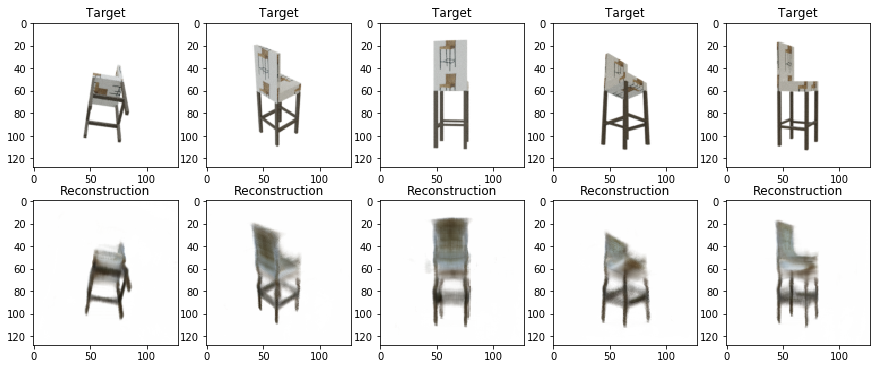

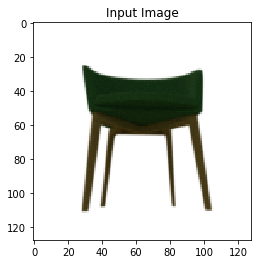

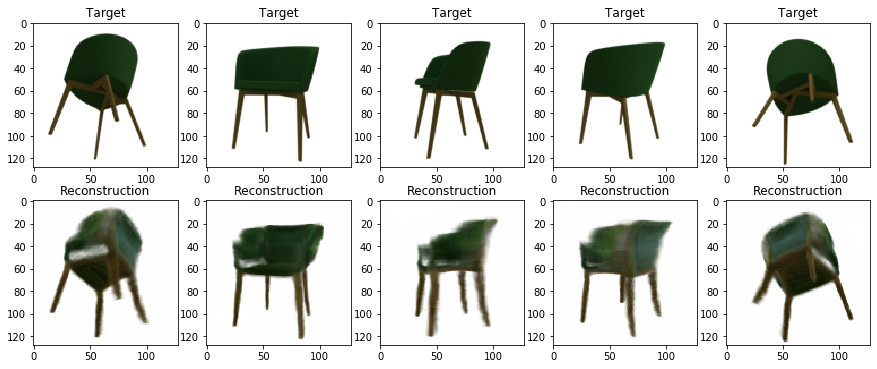

In [51]:
max_iters = 1000
num_views = 1 # How many views to test-time optimize over
lr= 0.5

N_samples = 128
model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))

for i in range(5):
    test_params, sup_images = train_single_model(max_iters, rng, num_views=num_views, lr=lr, init_params=params, image_idx=i)
    
    images, poses, hwf = load_train_ex(test_exs[i], rng)
    images, test_images = np.split(images, [25], axis=0)
    poses, test_poses = np.split(poses, [25], axis=0)
    
    if num_views == 1:
        plt.imshow(images[0])
        plt.title('Input Image')
        plt.show()
    
    plt.figure(figsize=(15,6))
    for j in range(5):
        test_rays = get_rays(hwf[0], hwf[1], hwf[2], test_poses[j])

        test_result = np.clip(render_fn(random.PRNGKey(0), model, test_params, test_rays, N_samples, rand=False)[0], 0, 1)

        plt.subplot(2,5,j+1)
        plt.imshow(test_images[j])
        plt.title('Target')
        plt.subplot(2,5,j+6)
        plt.imshow(test_result)
        plt.title('Reconstruction')
    plt.show()